In [1638]:
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Read in Data 

In [1639]:
def pr(df):
    p = pandas_profiling.ProfileReport(df)
    return p  

In [1640]:
jan18 = pd.read_csv("./jan18.csv")
jan18.columns

Index(['respid', 'sample', 'comp', 'int_date', 'lang', 'cregion', 'state',
       'density', 'usr', 'qs1', 'sex', 'eminuse', 'intmob', 'intfreq',
       'home4nw', 'bbhome1', 'bbhome2', 'device1a', 'smart2', 'snsint2',
       'device1b', 'device1c', 'device1d', 'web1a', 'web1b', 'web1c', 'web1d',
       'web1e', 'web1f', 'web1g', 'web1h', 'sns2a', 'sns2b', 'sns2c', 'sns2d',
       'sns2e', 'pial5a', 'pial5b', 'pial5c', 'pial5d', 'pial11', 'pial11a',
       'pial11ao@', 'pial11_igbm', 'pial12', 'books1', 'books2a', 'books2b',
       'books2c', 'age', 'marital', 'educ2', 'emplnw', 'hisp', 'racem1',
       'racem2', 'racem3', 'racem4', 'racecmb', 'birth_hisp', 'inc', 'party',
       'partyln', 'hh1', 'hh3', 'ql1', 'ql1a', 'qc1', 'weight', 'cellweight'],
      dtype='object')

In [1641]:
smart_cols = ['sex', 'hisp', 'age', 'educ2', 'inc', 'racem1', 'smart2']
dep_cols = smart_cols+['home4nw']

In [1642]:
jan18_smart = pd.read_csv("./jan18.csv", usecols = smart_cols)
jan18_dep = pd.read_csv("./jan18.csv", usecols = dep_cols)
dfs = [jan18_smart,jan18_dep]

In [1643]:
def pct(series, xlabel='', ylabel='', title=''):
    '''
    Return series of percentage distribution & histogram.
    '''
    vals = series.value_counts()
    s = vals/sum(vals)*100
    
    s.plot(kind = 'bar')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

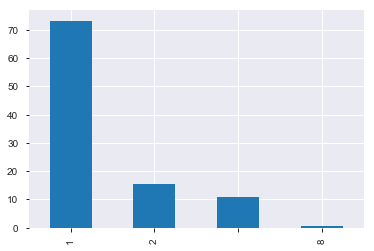

In [1644]:
pct(jan18_dep['home4nw'])

## Cleaning 

In [1645]:
def mapping(df, orig, new, d):
    '''
    Map values. Print new histogram.
    '''
    series = df[orig]
    series_new = series.map(d)
    
    new_df = df.drop(orig, axis = 1, inplace = False)
    new_df[new] = series_new
    return new_df

### Map

#### Age 

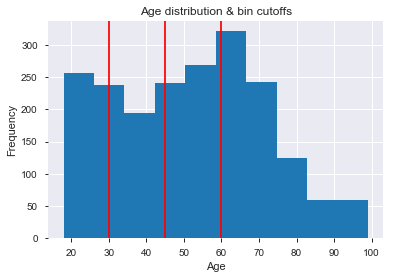

In [1646]:
ax = jan18_smart['age'].plot(kind = 'hist')
plt.xlabel('Age')
plt.title('Age distribution & bin cutoffs')

for xi in [30,45,60]:
    ax.axes.axvline(x=xi, color = 'r')
plt.savefig('age.png')

In [1647]:
def age(df):
    
    def bin_age(df, lower, upper, new):
        '''
        If lower < age <= upper put in bin 'new'.
        '''
        df.loc[(df['age'] > lower) & (df['age']<= upper), 'age'] = new

    lun = [(0, 30, 1), (30, 45,2), (45, 60, 3), (60, 97, 4), (97, 100, 0)] 
    # sets of lower upper and new

    for l, u, n in lun:
        bin_age(df, l, u, n)

In [1648]:
for d in dfs:
    age(d)

In [1649]:
def new_df(df, l):
    '''
    Given a df and a list, return the new df.
    '''
    orig, new, d = l
    new = mapping(df, orig, new, d)
    return new

In [1650]:
def loop(df, lists):
    '''
    Loop over lists doing transforms
    '''
    for l in lists:
        new = new_df(df, l)
        df = new
    return df

In [1651]:
smart_d = {'1' : 1, '2': 2, ' ':3, '8':0, '9':0}
smart = ['smart2', 'phone', smart_d]
# blank means landline sample and answered no to Device1a ("do you have a cell phone?"). Hence, values are strings.

educ_d = {1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 8:8, 98: 0, 99: 0}
educ = ['educ2', 'educ', educ_d]

hisp_d = {1:1, 2:2, 8:0, 9:0}
hisp = ['hisp', 'non_hisp', hisp_d]

inc_d = {1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 8:8, 9:9, 98: 0, 99: 0}
inc = ['inc', 'inc', inc_d]

#race_d = {1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 8:0, 9:0}
race_d = {1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 8:0, 9:0}
race = ['racem1', 'race', race_d]

In [1652]:
dep_d = {'1' : 1, '2': 2, ' ':3, '8':0}
dep = ['home4nw', 'broadband', dep_d]

In [1653]:
lists = [smart, educ, hisp, inc, race]

In [1654]:
df = loop(jan18_smart, lists)

In [1655]:
lists_dep = [smart, educ, hisp, inc, race, dep]

In [1656]:
df_dep = loop(jan18_dep, lists_dep)

### Remove rows with zeros 

In [1657]:
def remove_zero_rows(df):
    '''
    Return Data Frame with zero rows removed and index reseted.
    '''
    removed = df[(df != 0).all(1)]
    
    reset = removed.reset_index(drop=True)
    
    return reset

In [1658]:
df = remove_zero_rows(df)
df_dep = remove_zero_rows(df_dep)

In [1659]:
pr(df_dep)

Number of variables,8
Number of observations,1561
Total Missing (%),0.0%
Total size in memory,97.6 KiB
Average record size in memory,64.1 B
Numeric,6
Categorical,0
Boolean,2
Date,0
Text (Unique),0
Rejected,0


### Binarize 

#### Race 

In [1660]:
from sklearn.preprocessing import OneHotEncoder

In [1661]:
def binarize(df, col, val_names, leave_out=True):
    ''' 
    Given a Data Frame, a column name and its value names, binarizes that column in the data frame.
    If leave_out is true, you remove the last
    '''
    series = df[col]
    array_2d = series.values.reshape(-1,1)
    
    enc = OneHotEncoder()
    array = enc.fit(array_2d).transform(array_2d).toarray()
    df_col = pd.DataFrame(array, columns = val_names)
    
    
    dropped_df = df.drop(col, axis = 1, inplace = False)
    new_df = pd.concat([dropped_df, df_col], axis = 1)
    
    if leave_out:
        new_df.drop(val_names[-1], axis=1, inplace = True)  
    
    return new_df

In [1662]:
races = ['White', 'Black', 'Asian', 'Other', 'Native', 'Island', 'Hispanic']
races = [i.lower() for i in races]

In [1663]:
new_df = binarize(df, 'race', races)
new_df_dep = binarize(df_dep, 'race', races)

#### Label 

In [1664]:
smart_bin_d = {1 : 1, 2: 0, 3:0}
smart_bin = ['phone', 'smart_bin', smart_bin_d]

In [1665]:
df = mapping(new_df, smart_bin[0], smart_bin[1], smart_bin[2])

In [1666]:
dependence = pd.crosstab(index = new_df_dep['phone'], columns = new_df_dep['broadband'], normalize = True)
dependence

broadband,1,2,3
phone,,,
1,0.673286,0.119795,0.017297
2,0.082639,0.032671,0.045484
3,0.007687,0.001281,0.019859


In [1667]:
new_df_dep['dep'] = 0
new_df_dep.loc[(new_df_dep['broadband'] == 2) & (new_df_dep['phone']==1), 'dep'] = 1
df_dep = new_df_dep.drop(['phone', 'broadband'], axis = 1)

## Logistic Regression

In [1668]:
def split(df, label):
    y = df[label].values
    X = df.drop(label, axis = 1).values
    return X, y

In [1669]:
import statsmodels.api as sm
import numpy as np

def log_reg(X, y, yname, xnames):
    '''
    Given X and y and their names, print out Logistic Regression results
    '''
    
    # Add a constant to the numpy array
    num_obs = X.shape[0]
    const_vec = np.ones(num_obs).reshape((num_obs, 1))
    XplusConst = np.hstack((const_vec, X))

    # Run Model
    LogitModel = sm.Logit(y, XplusConst)
    LogitReg_sm = LogitModel.fit()
    print(LogitReg_sm.summary(yname, ['const']+xnames, 'Logistic Regression'))
    
    return LogitReg_sm

In [1670]:
def run_LR(df, label):
    '''
    Given name of label column, run LR.
    '''
    
    X, y = split(df, label)
    
    xnames = list(df.columns.drop(label))
    
    lr = log_reg(X, y, label, xnames)
    
    return lr

### Smartphone

In [1671]:
df = df.drop(['island'], axis = 1)

In [1672]:
lr = run_LR(df, 'smart_bin')

Optimization terminated successfully.
         Current function value: 0.377380
         Iterations 8
                             Logistic Regression                              
Dep. Variable:              smart_bin   No. Observations:                 1567
Model:                          Logit   Df Residuals:                     1556
Method:                           MLE   Df Model:                           10
Date:                Mon, 30 Jul 2018   Pseudo R-squ.:                  0.2243
Time:                        03:02:07   Log-Likelihood:                -591.35
converged:                       True   LL-Null:                       -762.30
                                        LLR p-value:                 2.086e-67
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8539      0.493      5.785      0.000       1.887       3.821
sex           -0.0680      0.

### Dependence 

In [1673]:
df_dep = df_dep.drop(['island'], axis = 1)

In [1674]:
lr = run_LR(df_dep, 'dep')

Optimization terminated successfully.
         Current function value: 0.309599
         Iterations 7
                             Logistic Regression                              
Dep. Variable:                    dep   No. Observations:                 1561
Model:                          Logit   Df Residuals:                     1550
Method:                           MLE   Df Model:                           10
Date:                Mon, 30 Jul 2018   Pseudo R-squ.:                  0.1553
Time:                        03:02:07   Log-Likelihood:                -483.28
converged:                       True   LL-Null:                       -572.13
                                        LLR p-value:                 7.050e-33
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1882      0.469      4.670      0.000       1.270       3.107
sex           -0.2251      0.

### One variable

In [1675]:
def univariate(df, col, label):
    '''
    Given data frame and name of predictor and label, output logistic regression.
    '''
    
    TO_DROP = df.columns.drop([label, col])
    col_df = df.drop(TO_DROP, axis = 1)
    
    LR = run_LR(col_df, label)
    
    return LR

In [1676]:
lr = univariate(df, 'age', 'smart_bin')

Optimization terminated successfully.
         Current function value: 0.436205
         Iterations 7
                             Logistic Regression                              
Dep. Variable:              smart_bin   No. Observations:                 1567
Model:                          Logit   Df Residuals:                     1565
Method:                           MLE   Df Model:                            1
Date:                Mon, 30 Jul 2018   Pseudo R-squ.:                  0.1033
Time:                        03:02:08   Log-Likelihood:                -683.53
converged:                       True   LL-Null:                       -762.30
                                        LLR p-value:                 3.900e-36
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.9918      0.260     15.383      0.000       3.483       4.500
age           -0.8430      0.

In [1677]:
lr = univariate(df_dep, 'age', 'dep')

Optimization terminated successfully.
         Current function value: 0.348408
         Iterations 6
                             Logistic Regression                              
Dep. Variable:                    dep   No. Observations:                 1561
Model:                          Logit   Df Residuals:                     1559
Method:                           MLE   Df Model:                            1
Date:                Mon, 30 Jul 2018   Pseudo R-squ.:                 0.04941
Time:                        03:02:08   Log-Likelihood:                -543.86
converged:                       True   LL-Null:                       -572.13
                                        LLR p-value:                 5.522e-14
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6929      0.179     -3.872      0.000      -1.044      -0.342
age           -0.5287      0.

In [1678]:
lr = univariate(df, 'inc', 'smart_bin')

Optimization terminated successfully.
         Current function value: 0.445696
         Iterations 6
                             Logistic Regression                              
Dep. Variable:              smart_bin   No. Observations:                 1567
Model:                          Logit   Df Residuals:                     1565
Method:                           MLE   Df Model:                            1
Date:                Mon, 30 Jul 2018   Pseudo R-squ.:                 0.08382
Time:                        03:02:08   Log-Likelihood:                -698.41
converged:                       True   LL-Null:                       -762.30
                                        LLR p-value:                 1.244e-29
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0582      0.133      0.437      0.662      -0.203       0.320
inc            0.2962      0.

In [1679]:
lr = univariate(df_dep, 'inc', 'dep')

Optimization terminated successfully.
         Current function value: 0.337328
         Iterations 7
                             Logistic Regression                              
Dep. Variable:                    dep   No. Observations:                 1561
Model:                          Logit   Df Residuals:                     1559
Method:                           MLE   Df Model:                            1
Date:                Mon, 30 Jul 2018   Pseudo R-squ.:                 0.07964
Time:                        03:02:08   Log-Likelihood:                -526.57
converged:                       True   LL-Null:                       -572.13
                                        LLR p-value:                 1.349e-21
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6154      0.153     -4.010      0.000      -0.916      -0.315
inc           -0.3041      0.

In [1680]:
lr = univariate(df, 'sex', 'smart_bin')

Optimization terminated successfully.
         Current function value: 0.483610
         Iterations 6
                             Logistic Regression                              
Dep. Variable:              smart_bin   No. Observations:                 1567
Model:                          Logit   Df Residuals:                     1565
Method:                           MLE   Df Model:                            1
Date:                Mon, 30 Jul 2018   Pseudo R-squ.:                0.005885
Time:                        03:02:08   Log-Likelihood:                -757.82
converged:                       True   LL-Null:                       -762.30
                                        LLR p-value:                  0.002742
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0228      0.206      9.815      0.000       1.619       2.427
sex           -0.3863      0.

In [1681]:
lr = univariate(df_dep, 'sex', 'dep')

Optimization terminated successfully.
         Current function value: 0.366387
         Iterations 6
                             Logistic Regression                              
Dep. Variable:                    dep   No. Observations:                 1561
Model:                          Logit   Df Residuals:                     1559
Method:                           MLE   Df Model:                            1
Date:                Mon, 30 Jul 2018   Pseudo R-squ.:               0.0003529
Time:                        03:02:08   Log-Likelihood:                -571.93
converged:                       True   LL-Null:                       -572.13
                                        LLR p-value:                    0.5251
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.8502      0.239     -7.747      0.000      -2.318      -1.382
sex           -0.0997      0.

In [1682]:
lr = univariate(df, 'educ', 'smart_bin')

Optimization terminated successfully.
         Current function value: 0.464971
         Iterations 6
                             Logistic Regression                              
Dep. Variable:              smart_bin   No. Observations:                 1567
Model:                          Logit   Df Residuals:                     1565
Method:                           MLE   Df Model:                            1
Date:                Mon, 30 Jul 2018   Pseudo R-squ.:                 0.04420
Time:                        03:02:08   Log-Likelihood:                -728.61
converged:                       True   LL-Null:                       -762.30
                                        LLR p-value:                 2.232e-16
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0587      0.177      0.331      0.741      -0.289       0.407
educ           0.3074      0.

In [1684]:
lr = univariate(df_dep, 'educ', 'dep')

Optimization terminated successfully.
         Current function value: 0.345010
         Iterations 7
                             Logistic Regression                              
Dep. Variable:                    dep   No. Observations:                 1561
Model:                          Logit   Df Residuals:                     1559
Method:                           MLE   Df Model:                            1
Date:                Mon, 30 Jul 2018   Pseudo R-squ.:                 0.05868
Time:                        03:02:12   Log-Likelihood:                -538.56
converged:                       True   LL-Null:                       -572.13
                                        LLR p-value:                 2.527e-16
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3401      0.209     -1.628      0.103      -0.750       0.069
educ          -0.3777      0.

In [1687]:
lr = univariate(df, 'non_hisp', 'smart_bin')

Optimization terminated successfully.
         Current function value: 0.486290
         Iterations 5
                             Logistic Regression                              
Dep. Variable:              smart_bin   No. Observations:                 1567
Model:                          Logit   Df Residuals:                     1565
Method:                           MLE   Df Model:                            1
Date:                Mon, 30 Jul 2018   Pseudo R-squ.:               0.0003753
Time:                        03:07:16   Log-Likelihood:                -762.02
converged:                       True   LL-Null:                       -762.30
                                        LLR p-value:                    0.4494
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7029      0.346      4.916      0.000       1.024       2.382
non_hisp      -0.1373      0.

In [1686]:
lr = univariate(df_dep, 'non_hisp', 'dep')

Optimization terminated successfully.
         Current function value: 0.354548
         Iterations 6
                             Logistic Regression                              
Dep. Variable:                    dep   No. Observations:                 1561
Model:                          Logit   Df Residuals:                     1559
Method:                           MLE   Df Model:                            1
Date:                Mon, 30 Jul 2018   Pseudo R-squ.:                 0.03266
Time:                        03:02:17   Log-Likelihood:                -553.45
converged:                       True   LL-Null:                       -572.13
                                        LLR p-value:                 9.789e-10
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0199      0.312      0.064      0.949      -0.592       0.631
non_hisp      -1.1295      0.

In [1156]:
sex = LR.params[1]

In [ ]:
LR

### Interpreting Logistic Regression 

In [1157]:
crosstab = pd.crosstab(index = new_df_sex['smart_bin'], columns = new_df_sex['sex'])

In [1158]:
crosstab

sex,0,1
smart_bin,,
0,139,159
1,714,555


In [1159]:
male = crosstab[0]
fem = crosstab[1]

In [1160]:
male_smart = male[1]/male[0]
female_smart = fem[1]/fem[0]

In [1161]:
male_smart

5.1366906474820144

In [1162]:
female_smart

3.4905660377358489

In [1163]:
female_to_male= female_smart/male_smart

In [1164]:
female_to_male

0.67953596532952798

In [1165]:
np.exp(sex)

0.67953596532953631

In [1166]:
log_male = np.log(male_smart)
log_male

1.6364090292088926

## ML 

In [309]:
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report

#Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [49]:
X_v = X.values
y_v = y.loc[:,].values

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_v, y_v, test_size = .3,
                                                    random_state=25)

### Logistic Regression  

In [51]:
LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [52]:
y_pred = LogReg.predict(X_test)

In [53]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix

array([[377,  13],
       [ 55,  26]])

In [54]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.87      0.97      0.92       390
          1       0.67      0.32      0.43        81

avg / total       0.84      0.86      0.83       471



In [79]:
acc_log = round(LogReg.score(X_train, y_train) * 100,2)

In [56]:
LogReg.coef_

array([[-0.17201925,  0.97930273, -0.25156379,  0.02080828, -0.27120557,
        -0.12332654]])

In [57]:
LogReg.intercept_

array([-1.53336816])

### DT 

In [70]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, y_train) * 100, 2)
acc_decision_tree

90.510000000000005

In [59]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.86      0.89      0.88       390
          1       0.36      0.28      0.32        81

avg / total       0.77      0.79      0.78       471



### Random Forest 

In [69]:
rf = RandomForestClassifier(n_estimators=500)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
acc_rf = round(rf.score(X_train, y_train) * 100, 2)
acc_rf

90.510000000000005

### SVM 

In [62]:
linear_svc = LinearSVC()
linear_svc.fit(X_train, y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, y_train) * 100, 2)
acc_linear_svc

81.840000000000003

### KNN 

In [64]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
Y_pred = linear_svc.predict(X_test)
acc_knn = round(linear_svc.score(X_train, y_train) * 100, 2)
acc_knn

81.840000000000003

In [66]:
390/471

0.8280254777070064

### Table 

In [81]:
a = 'acc_'
l = ['log', 'decision_tree', 'rf', 'linear_sv', 'knn']
accuracy = [acc_log, acc_decision_tree, acc_rf, acc_linear_svc, acc_knn]

In [83]:
res = pd.DataFrame({
'model':['LR', 'DT', 'RF', 'SVM', 'KNN'],
'accuracy' : accuracy
}
)

In [84]:
res

,accuracy,model
0,81.66,LR
1,90.51,DT
2,90.51,RF
3,81.84,SVM
4,81.84,KNN


### Binarize 

In [ ]:
#race_f = pd.get_dummies(df_r['race'], drop_first=False) #should I drop?

In [ ]:
def binarize(orig_df, col):
    new_cols = pd.get_dummies(df_r[col], drop_first=False)
    new_df = orig_df.drop(col, axis = 1, inplace = False)
    new_df = pd.concat([new_df, new_cols], axis = 1)
    return new_df

In [ ]:
binarize(df_r, 'race')